# Shipping Network Optimization
## ENGG*3130 - Modelling Complex Systems
### Jason Quon (0969675) - jquon@uoguelph.ca
### Carter Porter (0990287) - cporte05@uoguelph.ca

This notebook explores the supply chain networks of three different shipping companies. The companies in question are UPS, FedEd, and USPS. This project aims to analyze and explain the differences in each company's supply chain and make suggestions on how to further optimize each system.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
from math import *
from networkx.algorithms.approximation import average_clustering
import warnings
warnings.filterwarnings('ignore')

We start by initializing dictionaries containing the locations of all the distribution centres for each company.

In [2]:
#          City         Lon     Lat
ups = dict(Louisville = (-85.7, 38.3),
           Chicago = (-87.6, 41.8),
           Philadelphia = (-75.2, 40.0),
           Ontario = (-117.6, 34.0),
           FortWorth = (-97.3, 32.8),
           Miami = (-80.2, 25.8),
           Columbia = (-81.0, 34.0))

fedex = dict(Anchorage = (-150.0, 61.2),
             Oakland = (-122.3, 37.8),
             FortWorth = (-97.3, 32.8), 
             Memphis = (-90.0, 35.2),
             Newark = (-74.2, 40.7),
             Miami = (-80.2, 25.8),
             Indianapolis = (-86.2, 39.8))

usps = dict(Atlanta = (-84.4, 33.7),
            Chicago = (-87.6, 41.9),
            Cincinnati = (-84.5, 39.1),
            Dallas = (-96.8, 32.8),
            LosAngeles = (-118.2, 34.0),
            NewJersey = (-74.4, 40.0),
            Washington = (-76.5, 38.5),
            Denver = (-105.0, 39.7),
            Detroit = (-83.0, 42.3),
            Greensboro = (-79.8, 36.1),
            Memphis = (-90.0, 35.1),
            Philadelphia = (-75.2, 39.9),
            Seattle = (-122.3, 47.6),
            Jacksonville = (-81.7, 30.3),
            KansasCity = (-98.5, 39.0),
            Pittsburgh = (-80.0, 40.4),
            SanFrancisco = (-122.4, 37.8))


Next we compute the distance between the company's superhub and each of its distribution centres then add it to a dictionary. It should be noted that all distances are measured in kilometers.

In [3]:
def superhub_distances(pos, superhub, distances):
    """
    pos: dictionary of node positions
    superhub: central node to calculate distance from
    distances: dictionary to update with path lengths
    
    returns: dictionary with path lengths
    """
    radius = 6373.0                     # Approximate radius of earth in km
    lat1 = radians(pos[superhub][1])    # Superhub longitude (y)
    lon1 = radians(pos[superhub][0])    # Superhub latitude (x)
    for key in pos:
        if (key != superhub):           # Do not calculate the distance between the city and itself
            lat2 = radians(pos[key][1]) # Distribution centre latitude
            lon2 = radians(pos[key][0]) # Distribution centre longitude

            ydist = lat2 - lat1
            xdist = lon2 - lon1

            a = sin(ydist / 2)**2 + cos(lat1) * cos(lat2) * sin(xdist / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            dist = round(radius * c, 2)               # Calculate distance
            distances.update({(superhub, key): dist}) #Add to dictionary
        
    return distances

We must also calculate the distances between each of the distribution centres in the complete graph model used by USPS.

In [4]:
def distributed_distances(pos, distances):
    """
    pos: dictionary of node positions
    distances: dictionary to update with path lengths
    
    returns: dictionary with path lengths
    """
    radius = 6373.0                       # Approximate radius of earth in km
    
    for i in pos:                         # Iterate through each node
        lat1 = radians(pos[i][1])         # Latitude of first distribution centre
        lon1 = radians(pos[i][0])         # Longitude of first distribution centre
        for j in pos:                     # Iterate through every other node
            if (i != j):                  # Do not calculate the distance between the city and itself
                lat2 = radians(pos[j][1]) # Latitude of second distribution centre
                lon2 = radians(pos[j][0]) # Longitude of second distribution centre

                ydist = lat2 - lat1
                xdist = lon2 - lon1

                a = sin(ydist / 2)**2 + cos(lat1) * cos(lat2) * sin(xdist / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))

                dist = round(radius * c, 2)      # Calculate distance
                distances.update({(i, j): dist}) # Add to dictionary
        
    return distances

Finally, we write functions to determine the average path length, shortest path, and longest path which allow us to make observations regarding each graph.

In [5]:
def avg_path_length(distances):
    """
    distances: dictionary with path lengths
    
    returns: (float) average path length
    """
    sum = 0
    count = 0
    for key in distances:
        count += 1 
        sum += distances[key]

    return round(sum/count, 2)

In [6]:
def shortest_path(distances):
    """
    distances: dictionary with path lengths
    
    returns: length of shortest path, name of first node, name of second node
    """
    shortest = 0
    for key in distances:
        if (shortest == 0):
            path = key
            shortest = distances[key]
        else:
            if (distances[key] < shortest):
                path = key
                shortest = distances[key]
                
    return shortest, path[0], path[1]

In [7]:
def longest_path(distances):
    """
    distances: dictionary with path lengths
    
    returns: length of longest path, name of first node, name of second node
    """
    longest = 0
    for key in distances:
        if (distances[key] > longest):
            path = key
            longest = distances[key]
            
    return longest, path[0], path[1]


## Analysis of UPS

{('Louisville', 'Chicago'): Text(-86.65,40.05,'421.55'),
 ('Louisville', 'Columbia'): Text(-83.35,36.15,'637.73'),
 ('Louisville', 'FortWorth'): Text(-91.5,35.55,'1213.61'),
 ('Louisville', 'Miami'): Text(-82.95,32.05,'1483.11'),
 ('Louisville', 'Ontario'): Text(-101.65,36.15,'2890.08'),
 ('Louisville', 'Philadelphia'): Text(-80.45,39.15,'924.65')}

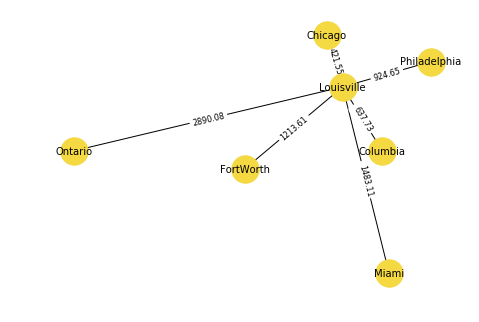

In [8]:
ups_graph = nx.Graph()        # Create graph
ups_graph.add_nodes_from(ups) # Add nodes from position dictionary

ups_distances = {}            # Initialize path length dictionary
ups_superhub = 'Louisville'   # Initialize superhub
ups_distances = superhub_distances(ups, ups_superhub, ups_distances)
ups_graph.add_edges_from(ups_distances) # Add edges from path length dictionary

# Draw graph
nx.draw(ups_graph, ups,
        node_color = '#f4d942', 
        font_size = 10,
        node_size = 750, 
        with_labels = True)

# Draw edge labels
nx.draw_networkx_edge_labels(ups_graph, ups,
                             edge_labels = ups_distances, 
                             font_size = 8)

In [9]:
print('Shortest Path:', shortest_path(ups_distances))
print('Longest Path:', longest_path(ups_distances))
print('Average Path Length:', avg_path_length(ups_distances))

Shortest Path: (421.55, 'Louisville', 'Chicago')
Longest Path: (2890.08, 'Louisville', 'Ontario')
Average Path Length: 1261.79


## Analysis of FedEx

{('Memphis', 'Anchorage'): Text(-120,48.2,'5051.54'),
 ('Memphis', 'FortWorth'): Text(-93.65,34,'723.92'),
 ('Memphis', 'Indianapolis'): Text(-88.1,37.5,'611.6'),
 ('Memphis', 'Miami'): Text(-85.1,30.5,'1403.83'),
 ('Memphis', 'Newark'): Text(-82.1,37.95,'1511.94'),
 ('Memphis', 'Oakland'): Text(-106.15,36.5,'2888.1')}

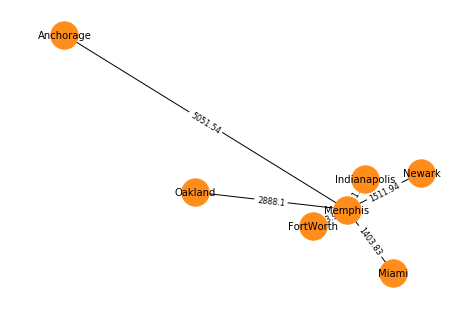

In [10]:
fedex_graph = nx.Graph()          # Create graph
fedex_graph.add_nodes_from(fedex) # Add nodes from position dictionary

fedex_distances = {}            # Initialize path length dictionary
fedex_superhub = 'Memphis'      # Initialize superhub
fedex_distances = superhub_distances(fedex, fedex_superhub, fedex_distances)
fedex_graph.add_edges_from(fedex_distances) # Add edges from path length dictionary

# Draw graph
nx.draw(fedex_graph, fedex,
        node_color = '#ff8d1c', 
        font_size = 10,
        node_size = 750, 
        with_labels = True)

# Draw edge labels
nx.draw_networkx_edge_labels(fedex_graph, fedex, 
                             edge_labels = fedex_distances, 
                             font_size = 8)

In [11]:
print('Shortest Path:', shortest_path(fedex_distances))
print('Longest Path:', longest_path(fedex_distances))
print('Average Path Length:', avg_path_length(fedex_distances))

Shortest Path: (611.6, 'Memphis', 'Indianapolis')
Longest Path: (5051.54, 'Memphis', 'Anchorage')
Average Path Length: 2031.82


## Analysis of USPS

{('Atlanta', 'Chicago'): Text(-86,37.8,'954.26'),
 ('Atlanta', 'Cincinnati'): Text(-84.45,36.4,'600.71'),
 ('Atlanta', 'Dallas'): Text(-90.6,33.25,'1157.08'),
 ('Atlanta', 'Denver'): Text(-94.7,36.7,'1949.14'),
 ('Atlanta', 'Detroit'): Text(-83.7,38,'964.37'),
 ('Atlanta', 'Greensboro'): Text(-82.1,34.9,'497.26'),
 ('Atlanta', 'Jacksonville'): Text(-83.05,32,'455.9'),
 ('Atlanta', 'KansasCity'): Text(-91.45,36.35,'1391.86'),
 ('Atlanta', 'LosAngeles'): Text(-101.3,33.85,'3108.12'),
 ('Atlanta', 'Memphis'): Text(-87.2,34.4,'536.93'),
 ('Atlanta', 'NewJersey'): Text(-79.4,36.85,'1131.55'),
 ('Atlanta', 'Philadelphia'): Text(-79.8,36.8,'1069.92'),
 ('Atlanta', 'Pittsburgh'): Text(-82.2,37.05,'841.1'),
 ('Atlanta', 'SanFrancisco'): Text(-103.4,35.75,'3436.75'),
 ('Atlanta', 'Seattle'): Text(-103.35,40.65,'3506.73'),
 ('Atlanta', 'Washington'): Text(-80.45,36.1,'887.75'),
 ('Chicago', 'Atlanta'): Text(-86,37.8,'954.26'),
 ('Chicago', 'Cincinnati'): Text(-86.05,40.5,'407.06'),
 ('Chicago', '

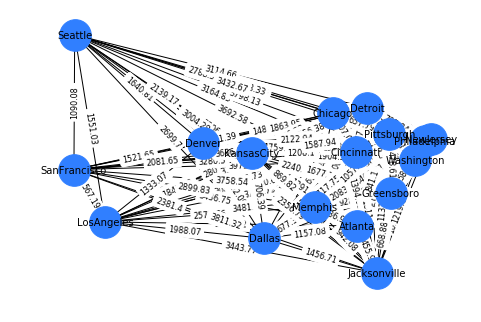

In [12]:
usps_graph = nx.Graph()         # Create graph
usps_graph.add_nodes_from(usps) # Add nodes from position dictionary

usps_distances = {}             # Initialize path length dictionary
usps_distances = distributed_distances(usps, usps_distances)
usps_graph.add_edges_from(usps_distances) # Add edges from path length dictionary

# Draw graph
nx.draw(usps_graph, usps,
        node_color = '#307fff', 
        font_size = 10,
        node_size = 1000, 
        with_labels = True)

# Draw edge labels
nx.draw_networkx_edge_labels(usps_graph, usps, 
                             edge_labels = usps_distances, 
                             font_size = 8)

In [13]:
print('Shortest Path:', shortest_path(usps_distances))
print('Longest Path:', longest_path(usps_distances))
print('Average Path Length:', avg_path_length(usps_distances))

Shortest Path: (69.12, 'NewJersey', 'Philadelphia')
Longest Path: (4111.75, 'NewJersey', 'SanFrancisco')
Average Path Length: 1740.49


# The Experiment: Can each system be optimized?

## Experiment 1: Can the systems used by UPS and FedEx be optimized further?
In this experiment we alter UPS and FedEx supernode location such to see if moving this will ultimately lower average path length. We do this by moving its location and recalculating the average path length. Assuming that each path is equally as common as the last, knowing the average path length allows us to determine if a more optimized location is possible.

In [14]:
def move_supernode_location(pos, superhub, distances):
    """
    pos: dictionary of node positions
    superhub: central node to calculate distance from
    distances: dictionary with path lengths
    
    returns: dictionary with better locations
    """
    betterLocs = []
    current_APL = avg_path_length(distances)
    long, lat = pos[superhub]
    temp_pos = {superhub: [long,lat]}
    
    for i in range(math.floor(long)-50, math.floor(long)+10):
        for j in range(math.floor(lat)-15, math.floor(lat)+15):
            test_location = { superhub: [i,j]}     # index i is longitude, index j is latitude
            pos.update(test_location)
            new_distances = superhub_distances(pos,superhub,distances)
            test_APL = avg_path_length(new_distances)
            if test_APL < current_APL:
                betterLocs.append({test_APL : [i,j]})
    pos.update(temp_pos)
    return betterLocs

In [15]:
print(avg_path_length(ups_distances))
betterLocs = move_supernode_location(ups,ups_superhub,ups_distances)
print(betterLocs)
print("There are " ,len(betterLocs) , " better locations than the current")

1261.79
[{1260.31: [-89, 36]}, {1255.06: [-88, 35]}, {1250.44: [-88, 36]}, {1253.15: [-88, 37]}, {1260.39: [-87, 34]}, {1248.11: [-87, 35]}, {1243.85: [-87, 36]}, {1247.06: [-87, 37]}, {1257.05: [-87, 38]}, {1255.98: [-86, 34]}, {1244.12: [-86, 35]}, {1240.71: [-86, 36]}, {1245.02: [-86, 37]}, {1256.28: [-86, 38]}, {1254.41: [-85, 34]}, {1243.25: [-85, 35]}, {1241.2: [-85, 36]}, {1247.18: [-85, 37]}, {1260.24: [-85, 38]}, {1255.81: [-84, 34]}, {1245.7: [-84, 35]}, {1245.66: [-84, 36]}, {1253.76: [-84, 37]}, {1260.31: [-83, 34]}, {1251.91: [-83, 35]}, {1254.71: [-83, 36]}]
There are  26  better locations than the current


In [16]:
print(avg_path_length(fedex_distances))
betterLocs = move_supernode_location(fedex,fedex_superhub,fedex_distances)
print(betterLocs)
print("There are " ,len(betterLocs) , "locations better than the current")

2031.82
[{2030.71: [-96, 36]}, {2025.49: [-96, 37]}, {2025.02: [-96, 38]}, {2029.43: [-96, 39]}, {2021.18: [-95, 36]}, {2014.42: [-95, 37]}, {2013.01: [-95, 38]}, {2016.94: [-95, 39]}, {2026.33: [-95, 40]}, {2029.82: [-94, 35]}, {2014.88: [-94, 36]}, {2006.2: [-94, 37]}, {2003.43: [-94, 38]}, {2006.57: [-94, 39]}, {2015.67: [-94, 40]}, {2030.75: [-94, 41]}, {2028.5: [-93, 35]}, {2011.2: [-93, 36]}, {2000.47: [-93, 37]}, {1996.1: [-93, 38]}, {1998.16: [-93, 39]}, {2006.81: [-93, 40]}, {2022.04: [-93, 41]}, {2029.26: [-92, 35]}, {2009.81: [-92, 36]}, {1996.98: [-92, 37]}, {1990.78: [-92, 38]}, {1991.55: [-92, 39]}, {1999.62: [-92, 40]}, {2015.02: [-92, 41]}, {2010.6: [-91, 36]}, {1995.62: [-91, 37]}, {1987.4: [-91, 38]}, {1986.62: [-91, 39]}, {1993.99: [-91, 40]}, {2009.66: [-91, 41]}, {2013.67: [-90, 36]}, {1996.49: [-90, 37]}, {1985.98: [-90, 38]}, {1983.28: [-90, 39]}, {1989.81: [-90, 40]}, {2005.99: [-90, 41]}, {2030.6: [-90, 42]}, {2019.34: [-89, 36]}, {1999.93: [-89, 37]}, {1986.77

In [17]:
# Using the theoretical superhub of Cinncinati
usps_superhub = 'Cincinnati'
print(avg_path_length(usps_distances))
betterLocs = move_supernode_location(usps,usps_superhub,usps_distances)
print(betterLocs)
print("There are " ,len(betterLocs) , "locations better than the current.")

1740.49
[{1740.19: [-89, 38]}, {1740.22: [-89, 39]}, {1740.39: [-88, 37]}, {1739.9: [-88, 38]}, {1739.88: [-88, 39]}, {1740.33: [-88, 40]}, {1740.37: [-87, 37]}, {1739.82: [-87, 38]}, {1739.76: [-87, 39]}, {1740.18: [-87, 40]}, {1739.97: [-86, 38]}, {1739.87: [-86, 39]}, {1740.29: [-86, 40]}, {1740.34: [-85, 38]}, {1740.22: [-85, 39]}]
There are  15 locations better than the current.


## Experiment 2: Transforming the system used by USPS
Looking at the USPS model we see that having a complete graph to represent the system creates an unreadable mess. In reality, distributing cargo from one distribution centre to every other is unnessecarily redundant. What happens if we strategically choose the most geographically centred distribution centres to be a superhub?

{('KansasCity', 'Atlanta'): Text(-91.45,36.35,'1391.86'),
 ('KansasCity', 'Chicago'): Text(-93.05,40.45,'976.52'),
 ('KansasCity', 'Cincinnati'): Text(-91.5,39.05,'1208.18'),
 ('KansasCity', 'Dallas'): Text(-97.65,35.9,'706.39'),
 ('KansasCity', 'Denver'): Text(-101.75,39.35,'564.35'),
 ('KansasCity', 'Detroit'): Text(-90.75,40.65,'1356.38'),
 ('KansasCity', 'Greensboro'): Text(-89.15,37.55,'1677.15'),
 ('KansasCity', 'Jacksonville'): Text(-90.1,34.65,'1811.9'),
 ('KansasCity', 'LosAngeles'): Text(-108.35,36.5,'1842.79'),
 ('KansasCity', 'Memphis'): Text(-94.25,37.05,'869.82'),
 ('KansasCity', 'NewJersey'): Text(-86.45,39.5,'2065.14'),
 ('KansasCity', 'Philadelphia'): Text(-86.85,39.45,'1998.05'),
 ('KansasCity', 'Pittsburgh'): Text(-89.25,39.7,'1587.94'),
 ('KansasCity', 'SanFrancisco'): Text(-110.45,38.4,'2081.65'),
 ('KansasCity', 'Seattle'): Text(-110.4,43.3,'2139.17'),
 ('KansasCity', 'Washington'): Text(-87.5,38.75,'1904.58')}

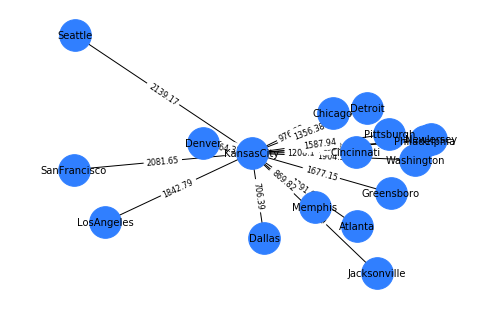

In [18]:
usps_distances.clear()                                                   # Remove edges
usps_graph.clear()                                                       # Remove graph
usps_superhub = 'KansasCity'                                             # Redefine superhub location
usps_graph.add_nodes_from(usps)                                          # Add nodes back
usps_distances = superhub_distances(usps, usps_superhub, usps_distances) # Compute new distances
usps_graph.add_edges_from(usps_distances)                                # Add edges

# Draw graph
nx.draw(usps_graph, usps,
        node_color = '#307fff', 
        font_size = 10,
        node_size = 1000, 
        with_labels = True)

# Draw edge labels
nx.draw_networkx_edge_labels(usps_graph, usps, 
                             edge_labels = usps_distances,
                             font_size = 8)

In [19]:
print('Shortest Path:', shortest_path(usps_distances))
print('Longest Path:', longest_path(usps_distances))
print('Average Path Length:', avg_path_length(usps_distances))

Shortest Path: (564.35, 'KansasCity', 'Denver')
Longest Path: (2139.17, 'KansasCity', 'Seattle')
Average Path Length: 1511.37


As noted above, we saw that UPS and FedEx had superhubs located in Louisville, Kentucky and Memphis, Tenessee. It should be noted that the distance between these cities is about 515km. This makes them relatively close to each other when considering the shear size of the United States. As USPS also has a distribution centre located in Memphis (but not Louisville), we may get a more fair comparison of each company's system by choosing this as the superhub.

{('Memphis', 'Atlanta'): Text(-87.2,34.4,'536.93'),
 ('Memphis', 'Chicago'): Text(-88.8,38.5,'784.59'),
 ('Memphis', 'Cincinnati'): Text(-87.25,37.1,'660.08'),
 ('Memphis', 'Dallas'): Text(-93.4,33.95,'677.38'),
 ('Memphis', 'Denver'): Text(-97.5,37.4,'1418.54'),
 ('Memphis', 'Detroit'): Text(-86.5,38.7,'1004.49'),
 ('Memphis', 'Greensboro'): Text(-84.9,35.6,'928.74'),
 ('Memphis', 'Jacksonville'): Text(-85.85,32.7,'942.08'),
 ('Memphis', 'KansasCity'): Text(-94.25,37.05,'869.82'),
 ('Memphis', 'LosAngeles'): Text(-104.1,34.55,'2577.76'),
 ('Memphis', 'NewJersey'): Text(-82.2,37.55,'1477.17'),
 ('Memphis', 'Philadelphia'): Text(-82.6,37.5,'1408.71'),
 ('Memphis', 'Pittsburgh'): Text(-85,37.75,'1057.7'),
 ('Memphis', 'SanFrancisco'): Text(-106.2,36.45,'2899.83'),
 ('Memphis', 'Seattle'): Text(-106.15,41.35,'3004.28'),
 ('Memphis', 'Washington'): Text(-83.25,36.8,'1259.05')}

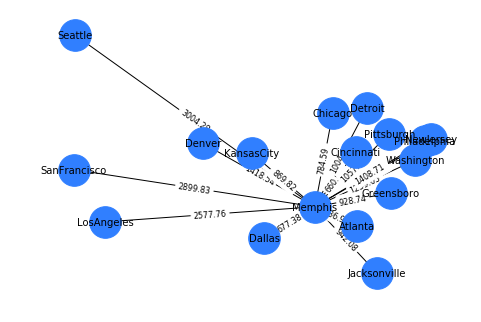

In [20]:
usps_distances.clear()                                                   # Remove edges
usps_graph.clear()                                                       # Remove nodes
usps_superhub = 'Memphis'                                                # Redefine superhub location
usps_graph.add_nodes_from(usps)                                          # Add nodes back
usps_distances = superhub_distances(usps, usps_superhub, usps_distances) # Compute new distances
usps_graph.add_edges_from(usps_distances)                                # Add edges

# Draw graph
nx.draw(usps_graph, usps,
        node_color = '#307fff', 
        font_size = 10,
        node_size = 1000, 
        with_labels = True)

# Draw edge labels
nx.draw_networkx_edge_labels(usps_graph, usps, 
                             edge_labels = usps_distances, 
                             font_size = 8)

In [21]:
print('Shortest Path:', shortest_path(usps_distances))
print('Longest Path:', longest_path(usps_distances))
print('Average Path Length:', avg_path_length(usps_distances))

Shortest Path: (536.93, 'Memphis', 'Atlanta')
Longest Path: (3004.28, 'Memphis', 'Seattle')
Average Path Length: 1344.2


What happens if we move the superhub to a location centred amongst a high concentration of nodes?

{('Cincinnati', 'Atlanta'): Text(-84.45,36.4,'600.71'),
 ('Cincinnati', 'Chicago'): Text(-86.05,40.5,'407.06'),
 ('Cincinnati', 'Dallas'): Text(-90.65,35.95,'1308.77'),
 ('Cincinnati', 'Denver'): Text(-94.75,39.4,'1759.42'),
 ('Cincinnati', 'Detroit'): Text(-83.75,40.7,'377.73'),
 ('Cincinnati', 'Greensboro'): Text(-82.15,37.6,'531.75'),
 ('Cincinnati', 'Jacksonville'): Text(-83.1,34.7,'1011.6'),
 ('Cincinnati', 'KansasCity'): Text(-91.5,39.05,'1208.18'),
 ('Cincinnati', 'LosAngeles'): Text(-101.35,36.55,'3046.18'),
 ('Cincinnati', 'Memphis'): Text(-87.25,37.1,'660.08'),
 ('Cincinnati', 'NewJersey'): Text(-79.45,39.55,'871.52'),
 ('Cincinnati', 'Philadelphia'): Text(-79.85,39.5,'802.77'),
 ('Cincinnati', 'Pittsburgh'): Text(-82.25,39.75,'411.04'),
 ('Cincinnati', 'SanFrancisco'): Text(-103.45,38.45,'3280.58'),
 ('Cincinnati', 'Seattle'): Text(-103.4,43.35,'3164.85'),
 ('Cincinnati', 'Washington'): Text(-80.5,38.8,'696.46')}

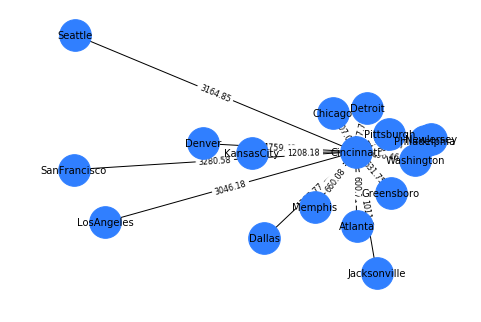

In [22]:
usps_distances.clear()                                                   # Remove edges
usps_graph.clear()                                                       # Remove nodes
usps_superhub = 'Cincinnati'                                             # Redefine supernode location
usps_graph.add_nodes_from(usps)                                          # Add nodes
usps_distances = superhub_distances(usps, usps_superhub, usps_distances) # Compute new distances
usps_graph.add_edges_from(usps_distances)                                # Add edges

# Draw graph
nx.draw(usps_graph, usps,
        node_color = '#307fff', 
        font_size = 10,
        node_size = 1000, 
        with_labels = True)

# Draw edge labels
nx.draw_networkx_edge_labels(usps_graph, usps, 
                             edge_labels = usps_distances, 
                             font_size = 8)

In [23]:
print('Shortest Path:', shortest_path(usps_distances))
print('Longest Path:', longest_path(usps_distances))
print('Average Path Length:', avg_path_length(usps_distances)) 

Shortest Path: (377.73, 'Cincinnati', 'Detroit')
Longest Path: (3280.58, 'Cincinnati', 'SanFrancisco')
Average Path Length: 1258.67


The results of these experiments are commented on indetail in the final report for this project.